In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, precision_recall_curve,confusion_matrix,auc,roc_auc_score,RocCurveDisplay, roc_curve,PrecisionRecallDisplay

import warnings
warnings.filterwarnings('ignore')

## read data

In [2]:
df = pd.read_csv('credit_card.txt')

In [3]:
df_origin = df.copy()

In [4]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
target = 'Class'

## EDA

In [6]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
df.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

Text(0, 0.5, '')

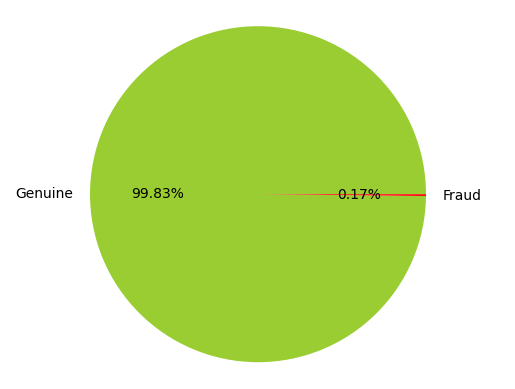

In [8]:
fig, ax = plt.subplots(1, 1)
ax.pie(df.Class.value_counts(),autopct='%1.2f%%', labels=['Genuine','Fraud'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

very unbalanced dataset - 0.17% of fraud

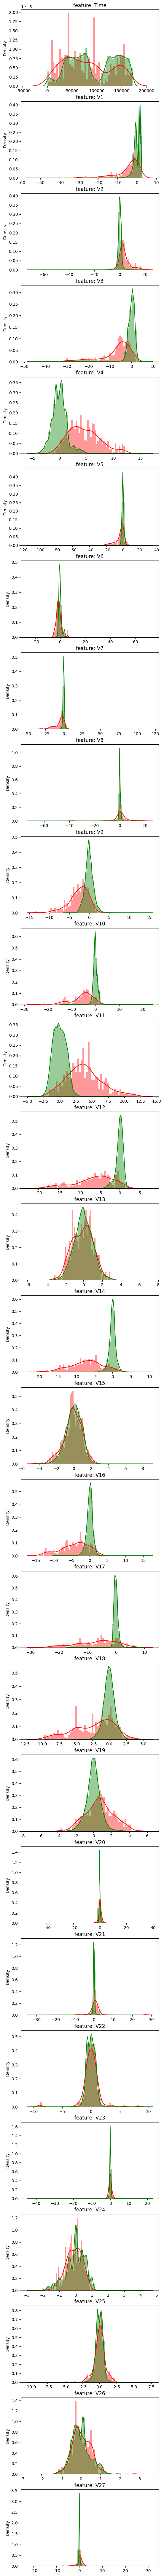

In [9]:
# check correlations of 25 components
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(28, 1)
plt.figure(figsize=(6,28*4))
for i, col in enumerate(df[df.iloc[:,0:28].columns]):
    ax5 = plt.subplot(gs[i])
    sns.distplot(df[col][df.Class == 1], bins=50, color='r')
    sns.distplot(df[col][df.Class == 0], bins=50, color='g')
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(col))
plt.show()

In [10]:
# drop columns where fraud class almost have no differences from non-fraud
df = df.drop(['V14','V16','V21','V23','V24','V26'],axis=1)

In [11]:
df = df.drop(['Time'],axis=1)

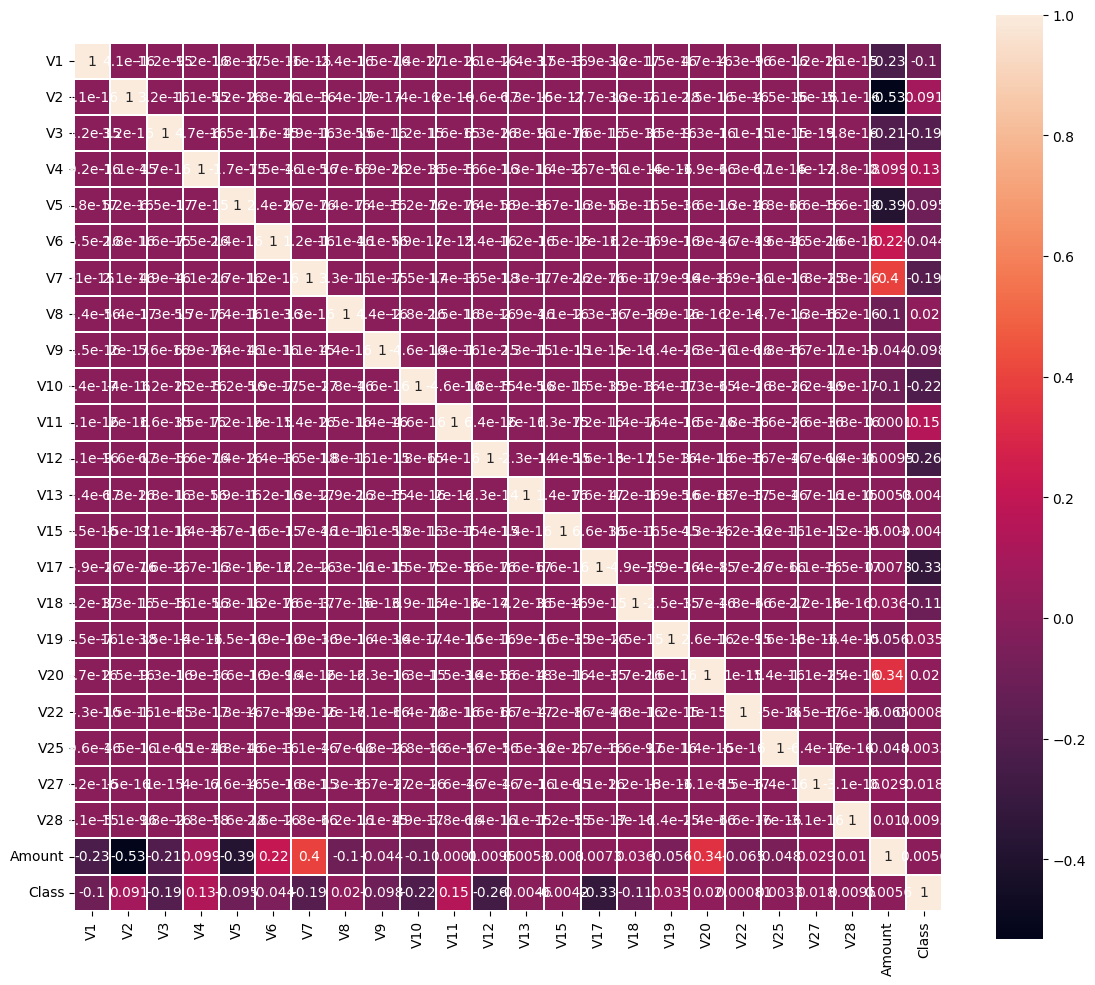

In [12]:
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True,linecolor='white', annot=True)
plt.show()

## create an underfitted balanced dataset

In [13]:
normal = df[df.Class == 0]
fraud = df[df.Class == 1]

In [14]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [15]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [16]:
normal_sample = normal.sample(n=len(fraud))

In [17]:
df_balanced = pd.concat([normal_sample,fraud])
df_balanced = df_balanced.reset_index(drop=True)

In [18]:
df_balanced.shape

(984, 24)

## splitting into features and targets

In [19]:
def split(df):
    X = df.drop(columns='Class', axis=1)
    Y = df['Class']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)
    print(X.shape, X_train.shape, X_test.shape)
    return X_train, X_test, y_train, y_test

#### split data for simple dataset

In [20]:
X_train_, X_test_, y_train_, y_test_ = split(df)

(284807, 23) (227845, 23) (56962, 23)


#### split data for underfitted dataset

In [21]:
X_train_under, X_test_under, y_train_under, y_test_under = split(df_balanced)

(984, 23) (787, 23) (197, 23)


#### split data for overfitted dataset

In [22]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_over = df.drop(columns=target, axis=1)
y_over = df[target]
X_over, y_over = sm.fit_resample(X_over,y_over)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.2, stratify=y_over, random_state=2)
print(X_train_over.shape, X_test_over.shape)

(454904, 23) (113726, 23)


#### functions for print and plot metrics

In [23]:
def print_metrix(y_test,y_pred,y_pred_prob):
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    print("accuracy score: ", accuracy_score(y_test,y_pred))
    print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
    

In [24]:
def plot_metrics(y_test, y_pred_prob):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

## 1. Naive Bayes Classifier

In [25]:
bayes = GaussianNB()

In [26]:
bayes.fit(X_train_,y_train_)

GaussianNB()

In [27]:
y_pred_ = bayes.predict(X_test_)
y_pred_prob_ = bayes.predict_proba(X_test_)[:,1]

In [28]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[55668  1196]
 [   14    84]]
recall score:  0.8571428571428571
precision score:  0.065625
f1 score:  0.12191582002902758
accuracy score:  0.978757768336786
ROC AUC: 0.9645802767505427


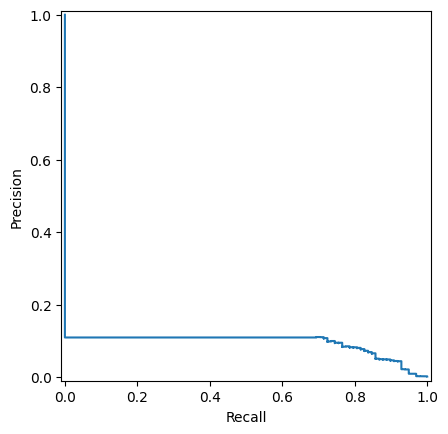

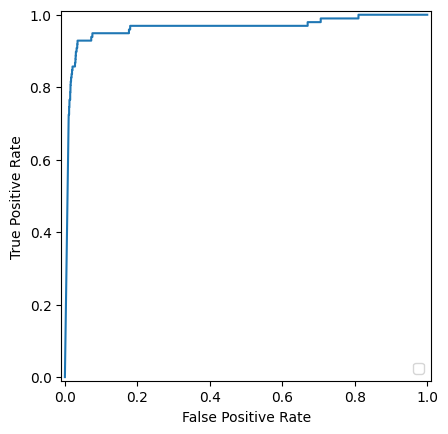

In [29]:
plot_metrics(y_test_, y_pred_prob_)

In [30]:
X_train_under, X_test_under, y_train_under, y_test_under = split(df_balanced)

(984, 23) (787, 23) (197, 23)


In [31]:
bayes.fit(X_train_under,y_train_under)

GaussianNB()

In [32]:
y_pred_under = bayes.predict(X_test_under)
y_pred_prob_under = bayes.predict_proba(X_test_under)[:,1]

In [33]:
print_metrix(y_test_under,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[97  2]
 [17 81]]
recall score:  0.826530612244898
precision score:  0.9759036144578314
f1 score:  0.8950276243093923
accuracy score:  0.9035532994923858
ROC AUC: 0.9535147392290249


In [34]:
bayes.fit(X_train_over,y_train_over)

GaussianNB()

In [35]:
y_pred_over = bayes.predict(X_test_over)
y_pred_prob_over = bayes.predict_proba(X_test_over)[:,1]

In [36]:
print_metrix(y_test_over,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[55406  1457]
 [ 9509 47354]]
recall score:  0.8327735082566872
precision score:  0.970150171067997
f1 score:  0.8962280220300168
accuracy score:  0.9035752598350422
ROC AUC: 0.9550554916070784


## 2. Logistic Regression

In [37]:
lr = LogisticRegression()

In [38]:
lr.fit(X_train_,y_train_)

LogisticRegression()

In [39]:
y_pred = lr.predict(X_test_)
y_pred_prob = lr.predict_proba(X_test_)[:,1]

In [40]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[55668  1196]
 [   14    84]]
recall score:  0.8571428571428571
precision score:  0.065625
f1 score:  0.12191582002902758
accuracy score:  0.978757768336786
ROC AUC: 0.9645802767505427


In [41]:
lr.fit(X_train_under, y_train_under)

LogisticRegression()

In [42]:
y_pred_under = lr.predict(X_test_under)
y_pred_prob_under = lr.predict_proba(X_test_under)[:,1]

In [43]:
print_metrix(y_test_under,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[93  6]
 [ 8 90]]
recall score:  0.9183673469387755
precision score:  0.9375
f1 score:  0.9278350515463918
accuracy score:  0.9289340101522843
ROC AUC: 0.9787672644815502


In [44]:
lr.fit(X_train_over, y_train_over)

LogisticRegression()

In [45]:
y_pred_over = lr.predict(X_test_over)
y_pred_prob_over = lr.predict_proba(X_test_over)[:,1]

In [46]:
print_metrix(y_test_over,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[55684  1179]
 [ 4044 52819]]
recall score:  0.9288816981165257
precision score:  0.9781658579947405
f1 score:  0.952886948521121
accuracy score:  0.954073826565605
ROC AUC: 0.9872511442456455


### 3. Random Forest

In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [49]:
rf.fit(X_train_,y_train_)

RandomForestClassifier()

In [50]:
y_pred_ = rf.predict(X_test_)
y_pred_prob_ = rf.predict_proba(X_test_)[:,1]

In [51]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[56856     8]
 [   19    79]]
recall score:  0.8061224489795918
precision score:  0.9080459770114943
f1 score:  0.8540540540540541
accuracy score:  0.9995259997893332
ROC AUC: 0.9577049393899371


In [52]:
rf.fit(X_train_under,y_train_under)

RandomForestClassifier()

In [53]:
y_pred_under = rf.predict(X_test_under)
y_pred_prob_under = rf.predict_proba(X_test_under)[:,1]

In [54]:
print_metrix(y_test_under,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[96  3]
 [ 9 89]]
recall score:  0.9081632653061225
precision score:  0.967391304347826
f1 score:  0.9368421052631579
accuracy score:  0.9390862944162437
ROC AUC: 0.9672232529375387


In [55]:
rf.fit(X_train_over,y_train_over)

RandomForestClassifier()

In [56]:
y_pred_over = rf.predict(X_test_over)
y_pred_prob_over = rf.predict_proba(X_test_over)[:,1]

In [57]:
print_metrix(y_test_over,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[56848    15]
 [    0 56863]]
recall score:  1.0
precision score:  0.9997362776468933
f1 score:  0.9998681214337838
accuracy score:  0.9998681040395336
ROC AUC: 0.9999984242596683


In [58]:
rf.feature_importances_

array([0.01426284, 0.04246963, 0.05340338, 0.16062545, 0.01036873,
       0.02042556, 0.02404295, 0.01245287, 0.03365952, 0.17535249,
       0.09638283, 0.11142527, 0.00750185, 0.00662356, 0.12333339,
       0.03252823, 0.00959634, 0.0090366 , 0.00538235, 0.00611501,
       0.01477836, 0.00865763, 0.02157515])

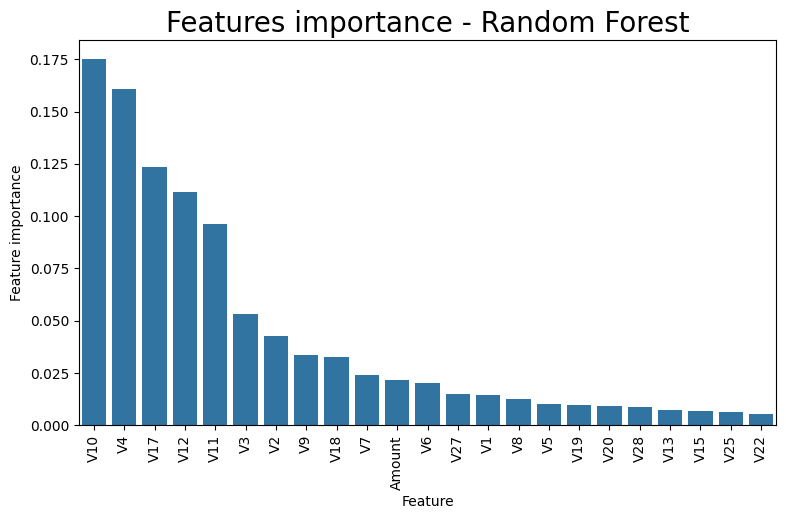

In [59]:
features = df.columns.drop(target)

plt.figure(figsize = (9,5))

feat_import = pd.DataFrame({'Feature': features, 'Feature importance': rf.feature_importances_})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)

g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('Features importance - Random Forest',fontsize=20)
plt.show() 

## 4. Boosting
#### 4.1 AdaBoost

In [60]:
from sklearn.ensemble import AdaBoostClassifier

In [61]:
ada = AdaBoostClassifier(random_state=2,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=100)

In [62]:
ada.fit(X_train_, y_train_)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2)

In [63]:
y_pred_ = ada.predict(X_test_)
y_pred_prob_ = ada.predict_proba(X_test_)[:,1]

In [64]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[56846    18]
 [   29    69]]
recall score:  0.7040816326530612
precision score:  0.7931034482758621
f1 score:  0.745945945945946
accuracy score:  0.9991748885221726
ROC AUC: 0.9842816874921043


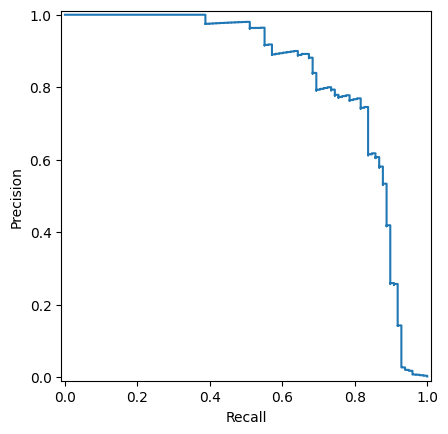

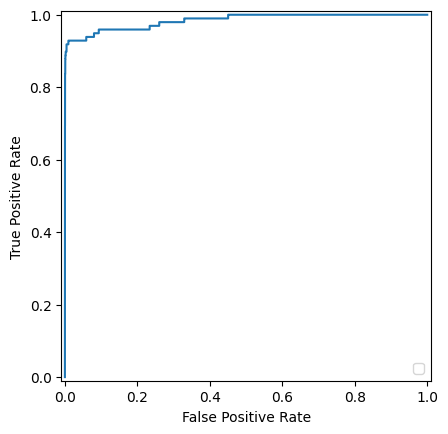

In [65]:
plot_metrics(y_test_, y_pred_prob_)

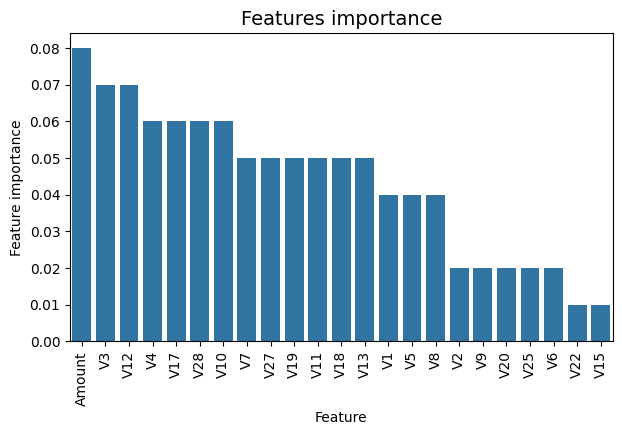

In [66]:
tmp = pd.DataFrame({'Feature': features, 'Feature importance': ada.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [67]:
ada.fit(X_train_under, y_train_under)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2)

In [68]:
y_pred_under = ada.predict(X_test_under)
y_pred_prob_under = ada.predict_proba(X_test_under)[:,1]

In [69]:
print_metrix(y_test_under,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[92  7]
 [13 85]]
recall score:  0.8673469387755102
precision score:  0.9239130434782609
f1 score:  0.8947368421052632
accuracy score:  0.8984771573604061
ROC AUC: 0.9399092970521542


In [70]:
ada.fit(X_train_over, y_train_over)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2)

In [71]:
y_pred_over = ada.predict(X_test_over)
y_pred_prob_over = ada.predict_proba(X_test_over)[:,1]

In [72]:
print_metrix(y_test_over,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[55950   913]
 [ 2138 54725]]
recall score:  0.9624008582030494
precision score:  0.983590351917754
f1 score:  0.9728802410645239
accuracy score:  0.9731723616411375
ROC AUC: 0.9976237328593275


#### 4.2 CatBoost

In [73]:
from catboost import CatBoostClassifier
ctb = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = 2,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=100)

In [74]:
ctb.fit(X_train_, y_train_)

0:	total: 932ms	remaining: 7m 45s
50:	total: 28.4s	remaining: 4m 10s
100:	total: 48.3s	remaining: 3m 10s
150:	total: 1m 8s	remaining: 2m 38s
200:	total: 1m 27s	remaining: 2m 10s
250:	total: 1m 47s	remaining: 1m 46s
300:	total: 2m 7s	remaining: 1m 24s
350:	total: 2m 26s	remaining: 1m 2s
400:	total: 2m 46s	remaining: 41.1s
450:	total: 3m 5s	remaining: 20.2s
499:	total: 3m 25s	remaining: 0us


In [75]:
y_pred_ = ctb.predict(X_test_)
y_pred_prob_ = ctb.predict_proba(X_test_)[:,1]

In [76]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[56859     5]
 [   20    78]]
recall score:  0.7959183673469388
precision score:  0.9397590361445783
f1 score:  0.861878453038674
accuracy score:  0.9995611109160493
ROC AUC: 0.9894162082390637


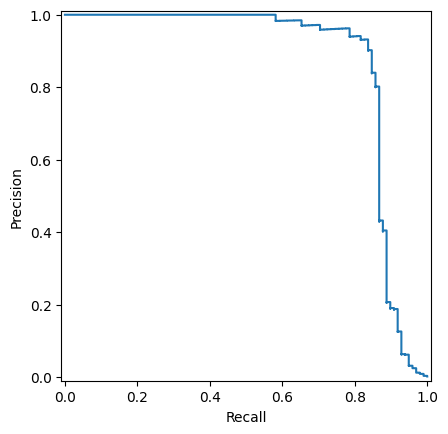

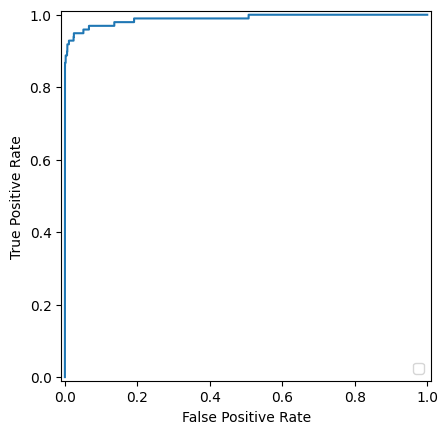

In [77]:
plot_metrics(y_test_, y_pred_prob_)

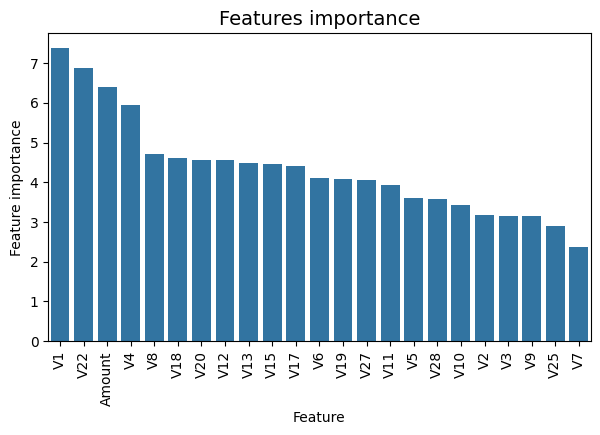

In [78]:
tmp = pd.DataFrame({'Feature': features, 'Feature importance': ctb.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

In [79]:
ctb.fit(X_train_under, y_train_under)

0:	total: 244ms	remaining: 2m 1s
50:	total: 12.5s	remaining: 1m 49s
100:	total: 24.8s	remaining: 1m 37s
150:	total: 37.1s	remaining: 1m 25s
200:	total: 49.4s	remaining: 1m 13s
250:	total: 1m 1s	remaining: 1m
300:	total: 1m 13s	remaining: 48.9s
350:	total: 1m 27s	remaining: 37s
400:	total: 1m 39s	remaining: 24.6s
450:	total: 1m 52s	remaining: 12.2s
499:	total: 2m 4s	remaining: 0us


In [80]:
y_pred_under = ctb.predict(X_test_under)
y_pred_prob_under = ctb.predict_proba(X_test_under)[:,1]

In [81]:
print_metrix(y_test_under,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[98  1]
 [13 85]]
recall score:  0.8673469387755102
precision score:  0.9883720930232558
f1 score:  0.9239130434782609
accuracy score:  0.9289340101522843
ROC AUC: 0.9755720470006185


In [82]:
ctb.fit(X_train_over, y_train_over)

0:	total: 546ms	remaining: 4m 32s
50:	total: 27.4s	remaining: 4m 1s
100:	total: 53.3s	remaining: 3m 30s
150:	total: 1m 18s	remaining: 3m
200:	total: 1m 42s	remaining: 2m 32s
250:	total: 2m 5s	remaining: 2m 4s
300:	total: 2m 30s	remaining: 1m 39s
350:	total: 2m 54s	remaining: 1m 13s
400:	total: 3m 17s	remaining: 48.8s
450:	total: 3m 41s	remaining: 24s
499:	total: 4m 4s	remaining: 0us


In [83]:
y_pred_over = ctb.predict(X_test_over)
y_pred_prob_over = ctb.predict_proba(X_test_over)[:,1]

In [84]:
print_metrix(y_test_over,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[56825    38]
 [    0 56863]]
recall score:  1.0
precision score:  0.9993321734240171
f1 score:  0.9996659751766815
accuracy score:  0.9996658635668185
ROC AUC: 0.9999660846248781


## 5. CNN

In [85]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization,Dropout,Dense,Flatten,Conv1D
from tensorflow.keras.optimizers import Adam

In [86]:
from sklearn.preprocessing import MinMaxScaler
X_train_scale = MinMaxScaler().fit_transform(np.array(X_train_))
X_test_scale = MinMaxScaler().fit_transform(np.array(X_test_))

In [87]:
model=Sequential()
model.add(Conv1D(32,2,activation='relu',input_shape=(23,1)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,2,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

In [88]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 22, 32)              │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 22, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 21, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1344)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          86,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,785 (354.63 KB)

 Trainable params: 90,593 (353.88 KB)

 Non-trainable params: 192 (768.00 B)

In [89]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy','precision','recall'])

In [90]:
epochs = 10

In [91]:
history = model.fit(X_train_scale,y_train_,epochs=epochs,validation_data=(X_test_scale,y_test_))

Epoch 1/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - accuracy: 0.9961 - loss: 0.0151 - precision: 0.3517 - recall: 0.3228 - val_accuracy: 0.9993 - val_loss: 0.0053 - val_precision: 0.8590 - val_recall: 0.6837
Epoch 2/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.9991 - loss: 0.0056 - precision: 0.8041 - recall: 0.6331 - val_accuracy: 0.9993 - val_loss: 0.0049 - val_precision: 0.8608 - val_recall: 0.6939
Epoch 3/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - accuracy: 0.9990 - loss: 0.0053 - precision: 0.8362 - recall: 0.5759 - val_accuracy: 0.9994 - val_loss: 0.0053 - val_precision: 0.8675 - val_recall: 0.7347
Epoch 4/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - accuracy: 0.9992 - loss: 0.0049 - precision: 0.8301 - recall: 0.6569 - val_accuracy: 0.9994 - val_loss: 0.0052 - val_precision: 0.8675 - val_recall: 0.7347
Epoch 5/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - accuracy: 0.9992 - loss: 0.0059 - precision: 0.8494 - recall: 0.6691 - val_accuracy: 0.9993

In [92]:
y_pred_prob_ = model.predict(X_test_scale)
f = lambda x: 0 if x<0.5 else 1
y_pred_ = list(map(f,y_pred_prob_))

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [93]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[56855     9]
 [   27    71]]
recall score:  0.7244897959183674
precision score:  0.8875
f1 score:  0.797752808988764
accuracy score:  0.9993679997191109
ROC AUC: 0.9810837601782412


In [94]:
def history_plot(metric):
    epochRange = range(1,epochs+1)
    plt.plot(epochRange,history.history[metric])
    plt.plot(epochRange,history.history[f'val_{metric}'])
    plt.title(f'Model {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{metric}')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

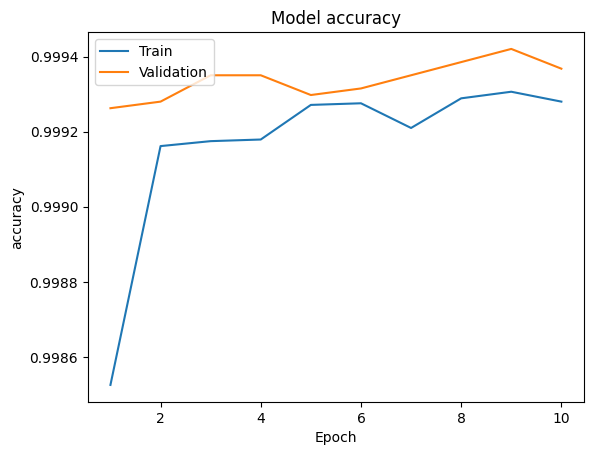

In [95]:
history_plot('accuracy')

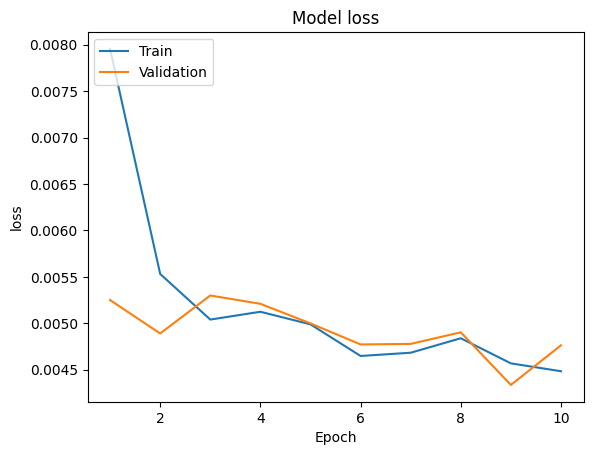

In [96]:
history_plot('loss')

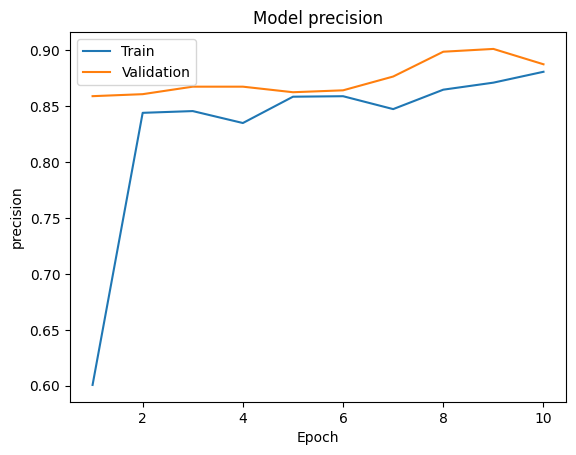

In [97]:
history_plot('precision')

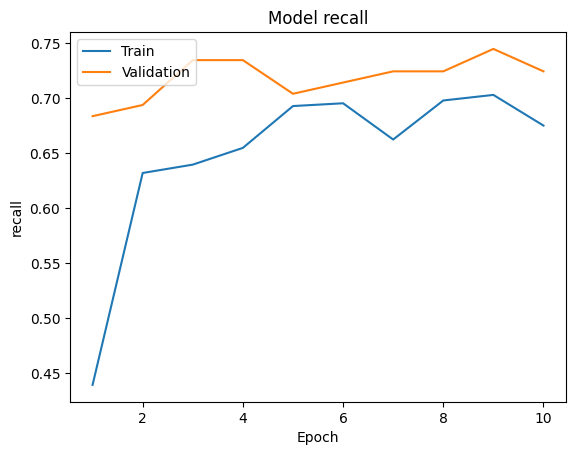

In [98]:
history_plot('recall')

## 6. Autoencoder

In [99]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [100]:
from sklearn.preprocessing import StandardScaler
df_origin['Time'] = StandardScaler().fit_transform(df_origin['Time'].values.reshape(-1, 1))
df_origin['Amount'] = StandardScaler().fit_transform(df_origin['Amount'].values.reshape(-1, 1))

In [101]:
X_train_, X_test_, y_train_, y_test_ = split(df_origin)

(284807, 30) (227845, 30) (56962, 30)


In [102]:
X_train_ = np.array(X_train_)
X_test_ = np.array(X_test_)

In [103]:
# data dimensions // hyperparameters 
INPUT_SHAPE = X_train_.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

In [104]:
from keras import regularizers

input_dim = X_train_.shape[1]
encoding_dim = int(INPUT_SHAPE / 2) - 1
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-7

input_layer = Input(shape=(INPUT_SHAPE, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(INPUT_SHAPE, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)


In [105]:
autoencoder.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 14)                  │             434 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             105 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30)                  │             240 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 835 (3.26 KB)

 Trainable params: 835 (3.26 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
autoencoder.compile(metrics=['accuracy','precision','recall'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [107]:
history = autoencoder.fit(X_train_, X_train_,
                    epochs=100,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(X_test_, X_test_),
                    verbose=1,
                    )

Epoch 1/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3799 - loss: 0.9863 - precision: 1.0000 - recall: 0.0705 - val_accuracy: 0.5823 - val_loss: 0.8295 - val_precision: 1.0000 - val_recall: 0.1211
Epoch 2/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6023 - loss: 0.8201 - precision: 1.0000 - recall: 0.1253 - val_accuracy: 0.6354 - val_loss: 0.7888 - val_precision: 1.0000 - val_recall: 0.1351
Epoch 3/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6344 - loss: 0.7973 - precision: 1.0000 - recall: 0.1369 - val_accuracy: 0.6436 - val_loss: 0.7764 - val_precision: 1.0000 - val_recall: 0.1413
Epoch 4/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6450 - loss: 0.7873 - precision: 1.0000 - recall: 0.1397 - val_accuracy: 0.6510 - val_loss: 0.7701 - val_precision: 1.0000 - val_recall: 0.1397
Epoch 5/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6529 - loss: 0.7868 - precision: 1.0000 - recall: 0.1409 - val_accuracy: 0.6549

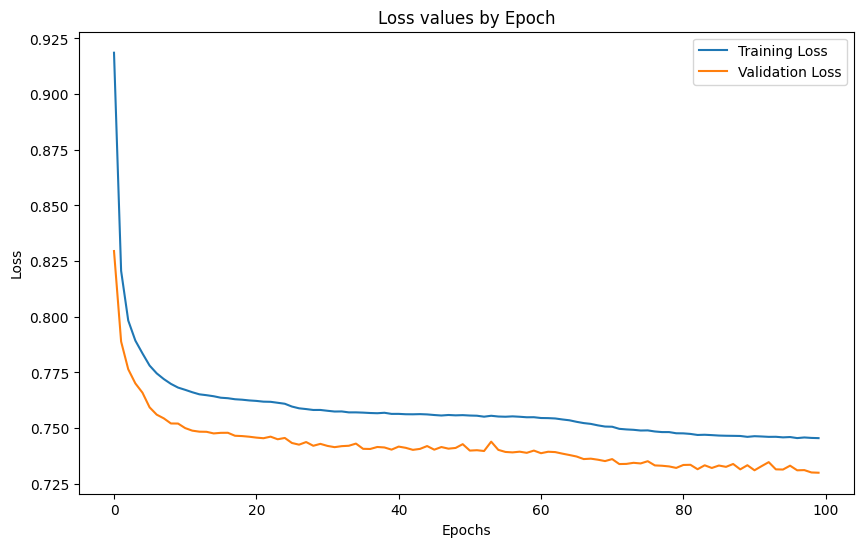

In [108]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss values by Epoch")
plt.show()

In [109]:
reconstructions = autoencoder.predict(X_test_, verbose=0)
reconstruction_error = mae(reconstructions, X_test_)

In [110]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test_
}).reset_index(drop=True)
recons_df

,error,y_true
0,0.350033,0
1,0.398939,0
2,0.468870,0
3,0.244875,0
4,0.571822,0
...,...,...
56957,0.305343,0
56958,0.486880,0
56959,0.522540,0
56960,0.528973,0


In [111]:
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix
def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    
    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']
        
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        
        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")
        
    return pd.DataFrame(thresh_df)
        
thresh_df = thresholdTuning(recons_df, 10)

Threshold: 0.1642	Accuracy: 0.002		Precision: 0.501	Recall Score: 0.500
Threshold: 0.2962	Accuracy: 0.102		Precision: 0.501	Recall Score: 0.550
Threshold: 0.3406	Accuracy: 0.202		Precision: 0.501	Recall Score: 0.600
Threshold: 0.3782	Accuracy: 0.302		Precision: 0.501	Recall Score: 0.650
Threshold: 0.4144	Accuracy: 0.402		Precision: 0.501	Recall Score: 0.695
Threshold: 0.4496	Accuracy: 0.502		Precision: 0.502	Recall Score: 0.740
Threshold: 0.4874	Accuracy: 0.602		Precision: 0.502	Recall Score: 0.790
Threshold: 0.5334	Accuracy: 0.702		Precision: 0.503	Recall Score: 0.835
Threshold: 0.5969	Accuracy: 0.802		Precision: 0.504	Recall Score: 0.880
Threshold: 0.7128	Accuracy: 0.901		Precision: 0.508	Recall Score: 0.915
